In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn import datasets
from logistic_regression import logistic_regression
%matplotlib inline

Определите AUC_ROC и AUC_PR для модели логистической регрессии на тестовой выборке. Используйте реализацию модели 
в виде класса и функцию confusion, чтобы рассчитать TPR, FPR, precision, recal для различных порогов вероятности.

In [2]:
classes = datasets.make_classification(n_samples=100, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=1)
np.random.seed(12)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]

Тренируем логистическую регрессию

In [3]:
lg = logistic_regression()
lg.fit(X_train, y_train)

Сохраняем уникальные значения вероятностей

In [ ]:
proba=np.unique(lg.predict_proba(X_test))

In [4]:
def confusion(predicted, actual):
    '''
    Функция подсчета значений матрицы ошибок
    '''
    TP=np.sum(np.logical_and(predicted==1, actual==1))
    FP=np.sum(np.logical_and(predicted==1, actual==0))
    FN=np.sum(np.logical_and(predicted==0, actual==1))
    TN=np.sum(np.logical_and(predicted==0, actual==0))
    return {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}

Вызываем функцию confusion для каждого значения вероятности и сохраняем результат в список conf_arr

In [5]:
conf_arr = []
for p in proba[::-1]:
    conf_mat = confusion(lg.predict(X_test, p), y_test)
    conf_arr.append(conf_mat)

Вычисляем TPR и FPR, используя список conf_arr

In [7]:
pos = np.sum(y_test)
neg = len(y_test) - pos
TPR = np.array([m['TP'] for m in conf_arr]/pos)
FPR = np.array([m['FP'] for m in conf_arr]/neg)

Добавляем единицы в конце для корректировки графика ROC-AUC

In [8]:
TPR = np.append(TPR, [1.])
FPR = np.append(FPR, [1.])

 Вычисляем ROC-AUC, используя формулу площади трапеции

In [9]:
trap_height = FPR[1:]-FPR[:-1]
trap_base = (TPR[1:]+TPR[:-1])
ROC_AUC = round(np.sum(trap_height * trap_base /2),4)

Чертим график и выводим значение ROC-AUC в правом нижнем углу

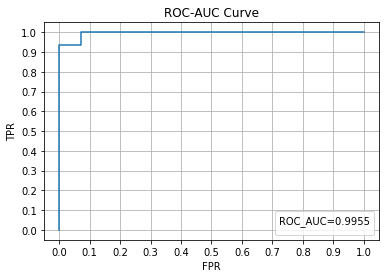

In [31]:
plt.title("ROC-AUC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))
plt.legend('', title=f'ROC_AUC={ROC_AUC}')
plt.plot(FPR, TPR);

Вычисляем значение recall = TP/(TP+FP) и также добавляем единицу в конце списка

In [13]:
recall = np.round(np.array([m['TP'] for m in conf_arr])/\
(np.array([m['TP'] for m in conf_arr] + np.array([m['FN'] for m in conf_arr]))),4)
recall = np.append(recall, 1.)

Вычисляем значение precision = TP/(TP+FP). Отдельно собираем значения для числителя и знаменателя, так как знаменатель может принимать и нулевые значения.

In [14]:
denominator = np.array([m['TP'] for m in conf_arr]) + np.array([m['FP'] for m in conf_arr])
numerator = np.array([m['TP'] for m in conf_arr])

Используем функцию numpy.divide для замещения nan единицей в случае делении на ноль

In [15]:
precision = np.round(np.divide(numerator, denominator, out=np.ones(numerator.shape, dtype="float"), \
                               where=denominator!=0),4)
precision = np.append(precision, 0.)

Используем функцию трапеции для вычисления площади PR-AUC

In [16]:
trap_height = recall[1:]-recall[:-1]
trap_base = (precision[1:]+precision[:-1])/2
PR_AUC = round(np.sum(trap_height * trap_base),4)

Выводим PR-AUC на графике вместе с кривыми precision и recall

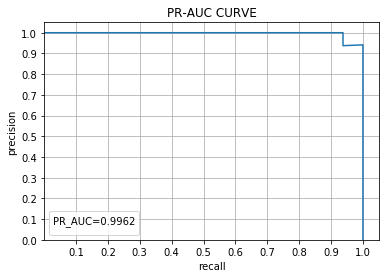

In [17]:
plt.title('PR-AUC CURVE')
plt.ylim(0,1.05)
plt.xlim(0,1.05)
plt.grid()
plt.legend('',title=f'PR_AUC={PR_AUC}')
plt.xticks(np.arange(0.1,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))
plt.xlabel('recall')
plt.ylabel('precision')
plt.plot(recall, precision);